# Setup package dependencies

In [1]:

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"


import numpy as np 
np.set_printoptions(precision=3)
import random

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.xmargin"] = 0
plt.rcParams["toolbar"] = "None"  
plt.rcParams["axes.titlesize"] = 10

from IPython.display import display

import tensorflow as tf
import tensorflow.keras as tfk


from pathlib import Path
import librosa

from sklearn.utils import shuffle
from utils import get_spectrogram, plot_spectrogram, plot_eval

#### Assure repeatability


In [2]:
import os

random_seed = 42
os.environ["PYTHONHASHSEED"] = "42"
np.random.seed(random_seed)
random.seed(random_seed)
tfk.utils.set_random_seed(random_seed)

# Get data

In [3]:
labels = []
data_dir = Path("DATA")
for subdir in data_dir.iterdir():
    if subdir.is_dir():
        labels.append(subdir.name)
label_names = labels
print(f"Labels: {labels}")

Labels: ['GUNS', 'ENV']


# E.D.A


#### Get some audio examples of each class


In [4]:
ex_data = []
ex_label = []
Nex = 10
for item in data_dir.glob("ENV/*.wav"):
    sr_in0 = librosa.get_samplerate(str(item))
    data, sr_in = librosa.load(str(item), sr=sr_in0, mono=True)
    data = librosa.resample(data, orig_sr=sr_in, target_sr=16000)
    ex_data.append(data)
    ex_label.append("ENV")
    if len(ex_data) == Nex:
        break
for item in data_dir.glob("GUNS/*.wav"):
    data, sr_in = librosa.load(str(item), mono=True)
    data = librosa.resample(data, orig_sr=sr_in, target_sr=16000)
    ex_data.append(data)
    ex_label.append("GUNS")
    if len(ex_data) == Nex:
        break

In [5]:
from IPython.display import Audio

print("Label:", ex_label[0])
print("Waveform shape:", ex_data[0].shape)
print("Audio playback")
Audio(ex_data[0], rate=16000)

Label: ENV
Waveform shape: (4096,)
Audio playback


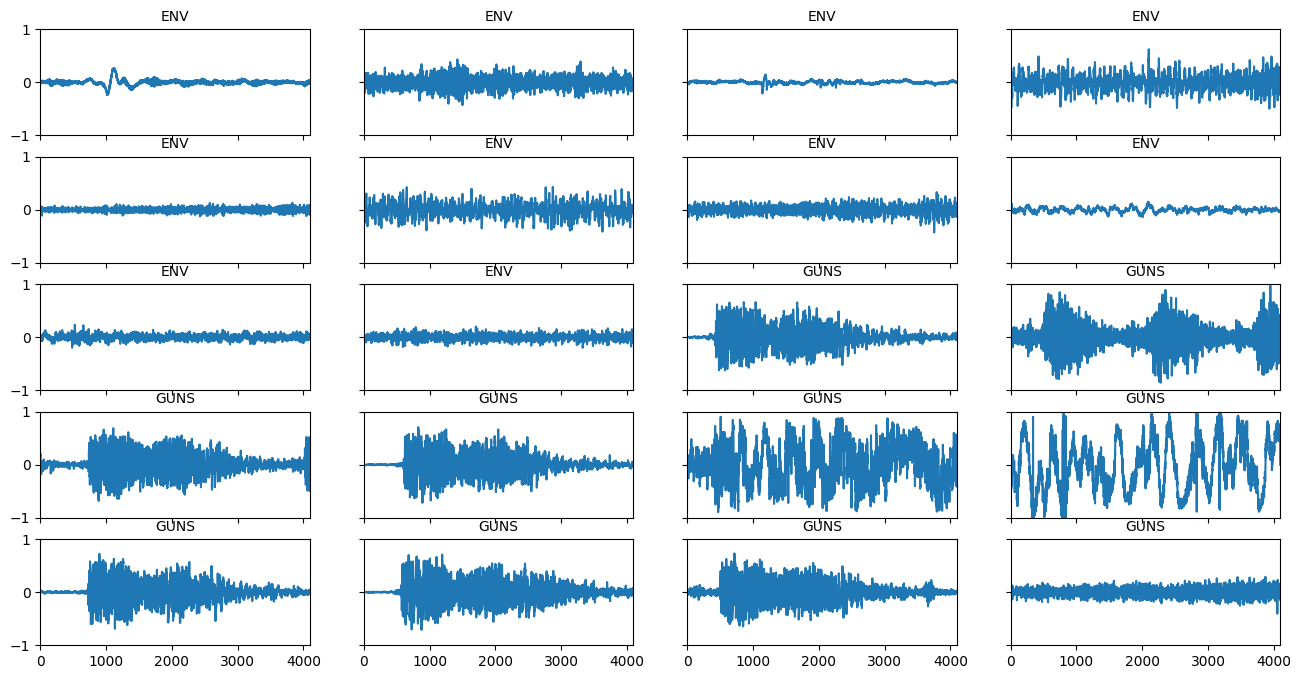

In [6]:
rows = 5
cols = 4
fig, ax = plt.subplots(
    nrows=rows, ncols=cols, figsize=(16, 8), sharex="all", sharey="all"
)
n = rows * cols
for i in range(n):
    ix = i
    plt.subplot(rows, cols, i + 1)
    plt.plot(ex_data[ix])
    plt.title(ex_label[ix])
    plt.ylim([-1, 1])

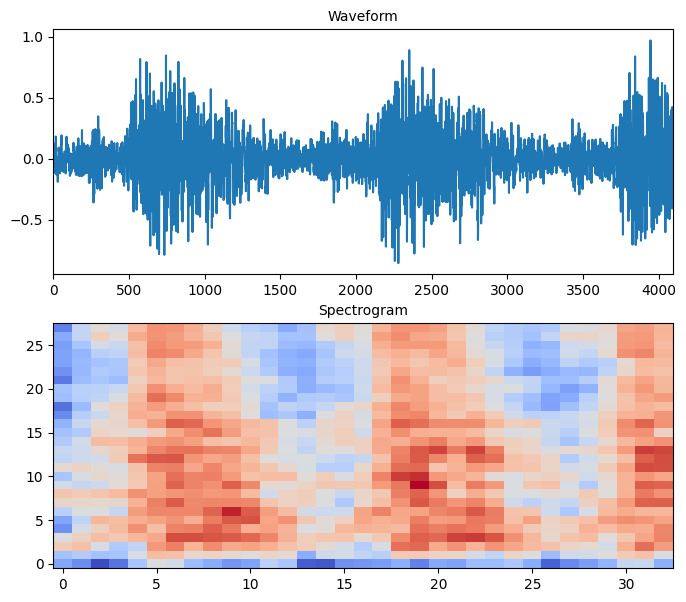

In [7]:
fig, ax = plt.subplots(2, figsize=(8, 7))
ax[0].plot(ex_data[11])
ax[0].set_title("Waveform")
Smel = get_spectrogram(ex_data[11])
plot_spectrogram(Smel, ax[1])
ax[1].set_title("Spectrogram")
plt.show()

In [8]:
Imean = np.mean(Smel)
Imax = np.max(Smel)
Imin = np.min(Smel)
Istd = np.std(Smel)
print(f"Max:  {Imax} \nMin:  {Imin} \nMean: {Imean} \nStd:  {Istd}")

Max:  -10.037713050842285 
Min:  -43.9183464050293 
Mean: -24.398229598999023 
Std:  6.195067882537842


## Generate dataset


In [19]:
# Feature extraction - Mel spectrogram:
def get_feature_mel(fname):
    sr_in0 = librosa.get_samplerate(fname)
    data, sr_in = librosa.load(fname, sr=sr_in0, mono=True)
    data = librosa.resample(data, orig_sr=sr_in, target_sr=16000)
    S = get_spectrogram(data)
    # print(f"{np.max(S)}")
    return S


def augment_mel(X, y):
    X_out = []
    y_out = []
    for i in range(X.shape[0]):
        # Augment probability
        if np.random.randint(100) < 33:
            x = X[i].copy()
            r, c = x.shape
            # Randomly select a section of the mel spectrogram to be attenuated [in dB]
            match np.random.randint(0, 12):
                case 0 | 1 | 2 | 3:  # White noise
                    # White noise
                    x = np.multiply(
                        x, np.random.uniform(low=0.7, high=0.99, size=x.shape)
                    )
                case 4 | 5 :  #  HP filter
                    x[0, :] -= 6
                    x[1, :] -= 3
                case 6 | 7 :  # LP filter
                    x[r - 1, :] -= 6
                    x[r - 2, :] -= 3
                case 8 :  #Sin tone
                    x[4] = -25
                    x[5] = -22
                    x[6] = -25
                case 9 :  #Sin tone
                    x[7] = -25
                case 10 :  #Sin tone
                    x[11] = -25
                case 11 :  #Sin tone
                    x[15] = -25

            X_out.append(x)
            y_out.append(y[i])
    return np.array(X_out), np.array(y_out)

In [20]:
X = []
y = []
grp = []
for item in data_dir.glob("*/*.wav"):
    # One hot encoding based on label name from dir structure
    t = np.zeros(len(labels), dtype=int)
    t[labels.index(item.parts[-2])] = 1

    # Get feature
    feat = get_feature_mel(str(item))
    X.append(feat)
    y.append(t)
    grp.append(item.stem)

X = np.array(X)
y = np.array(y)
grp = np.array(grp)

# Shuffle data
X, y,grp = shuffle(X, y, grp)

# Split: 80 -10 - 10%
Ntot = X.shape[0]
Ntrain = int(0.8 * Ntot)
Ntest = int(0.1 * Ntot)
Nval = Ntot - Ntrain - Ntest

X_train = X[:Ntrain]
y_train = y[:Ntrain]

X_val = X[Ntrain : Ntot - Ntest]
y_val = y[Ntrain : Ntot - Ntest]

X_test = X[Ntot - Ntest :]
y_test = y[Ntot - Ntest :]

print(f"Total samples: {y.shape[0]}")
print(f"Train samples: {y_train.shape[0]}")
print(f"Val samples: {y_val.shape[0]}")
print(f"Test samples: {y_test.shape[0]}")

# Convert to Dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Total samples: 7622
Train samples: 6097
Val samples: 763
Test samples: 762


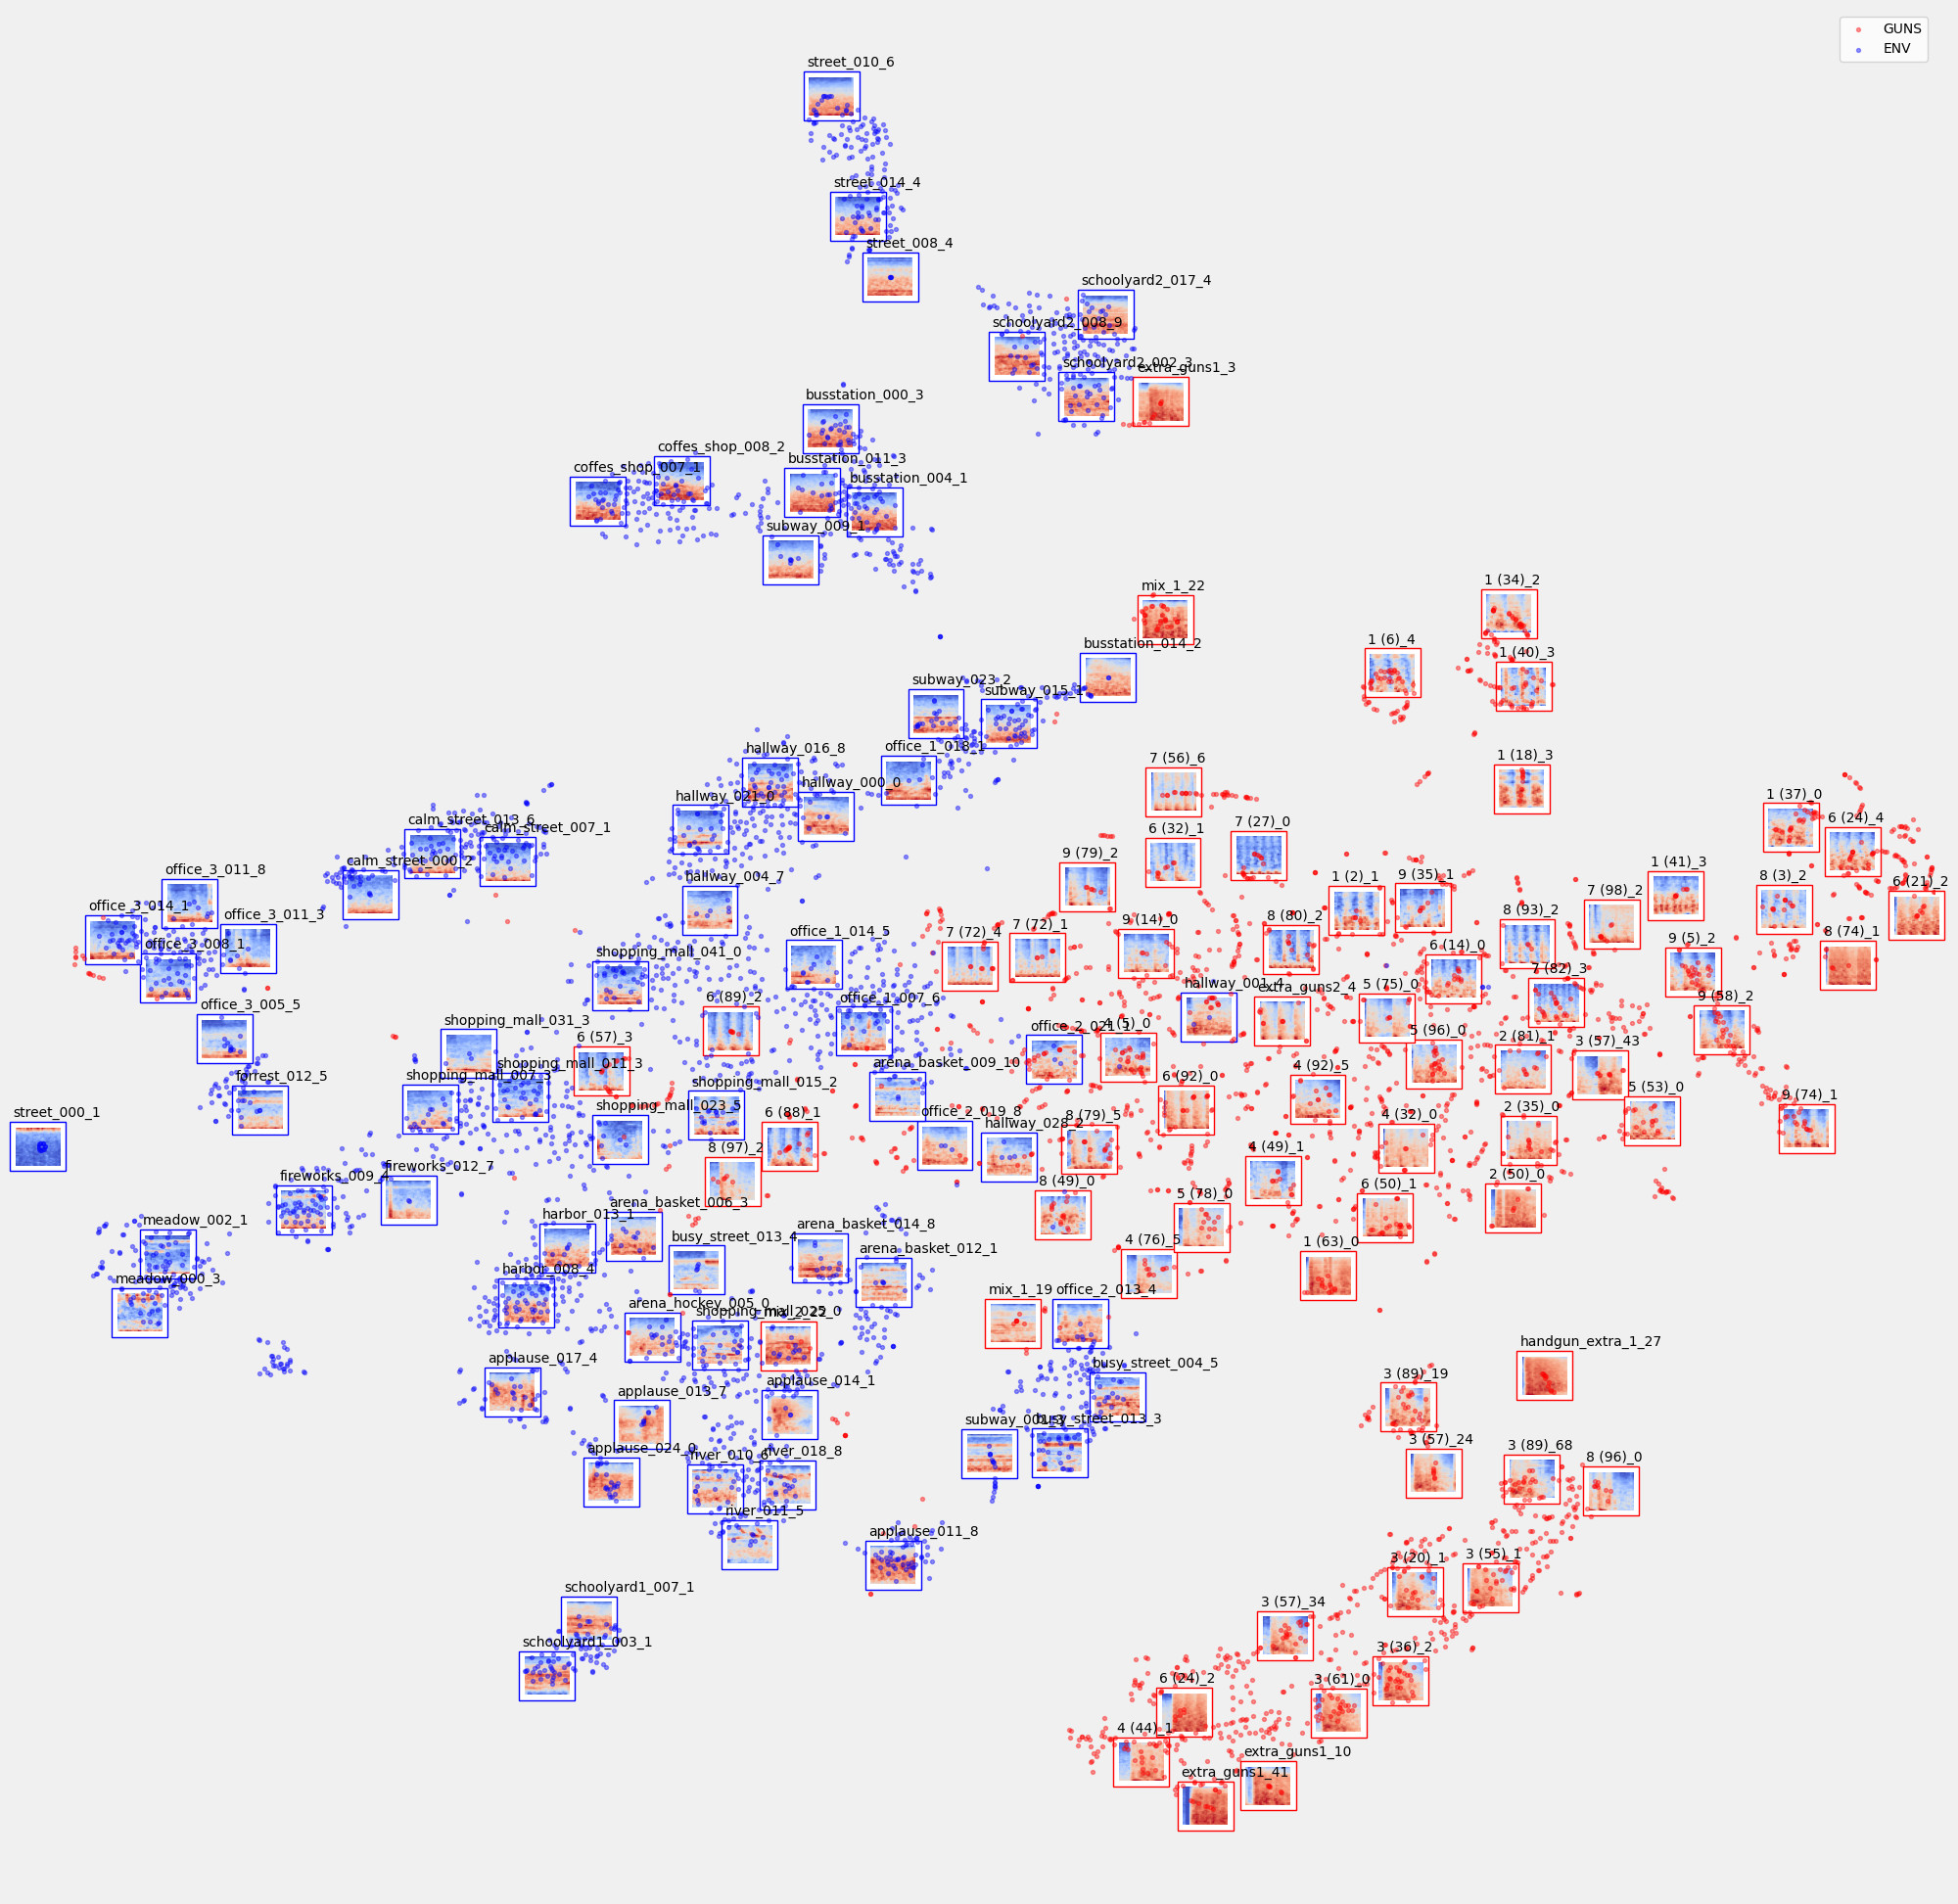

In [22]:
# Make a tSNE embedding to 2D and visualize
from sklearn.manifold import TSNE
from matplotlib import offsetbox

N = 6000
show_features = True
# show_features = False

# tSNE
tsne = TSNE(n_components=2, init="pca", random_state=0, perplexity=30, max_iter=2000)
y_tsne = np.argmax(y[:N], axis=1)
x_tsne = tsne.fit_transform(X[:N].reshape(N, -1))

grp_colors = ["red", "blue"]

fig, ax = plt.subplots(1, figsize=(7, 7),facecolor='#f0f0f0')
ax.scatter(
    x_tsne[y_tsne == 0, 0],
    x_tsne[y_tsne == 0, 1],
    s=8,
    c=grp_colors[0],
    alpha=0.4,
    label="GUNS",
)
ax.scatter(
    x_tsne[y_tsne == 1, 0],
    x_tsne[y_tsne == 1, 1],
    s=8,
    c=grp_colors[1],
    alpha=0.4,
    label="ENV",
)


if show_features:
    fig.set_figwidth(25)
    fig.set_figheight(25)
    shown_images = np.array([[1.0, 1.0]])

    for i in range(750):
        dist = np.sum((x_tsne[i] - shown_images) ** 2, 1)
        if np.min(dist) < 50:
            # don't show images that are too close
            continue
        shown_images = np.concatenate([shown_images, [x_tsne[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(X[i], cmap="coolwarm", origin="lower"),
            x_tsne[i],
            bboxprops=dict(ec=grp_colors[y_tsne[i]]),
        )
        imagebox.set(zorder=0)
        ax.add_artist(imagebox)
        ax.annotate(grp[i], x_tsne[i], xytext=(-25, 30), textcoords="offset pixels")
plt.legend()
plt.axis("off")
plt.show()

In [23]:
# Augment training data
X_aug, y_aug = augment_mel(X_train, y_train)

X_train = np.concatenate((X_aug, X_train), axis=0)
y_train = np.concatenate((y_aug, y_train), axis=0)

print(f"Adding augmented samples:  {y_aug.shape[0]}")
print(f"New total traning samples: {y_train.shape[0]}")

X_train, y_train = shuffle(X_train, y_train)

# Convert to Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

Adding augmented samples:  2007
New total traning samples: 8104


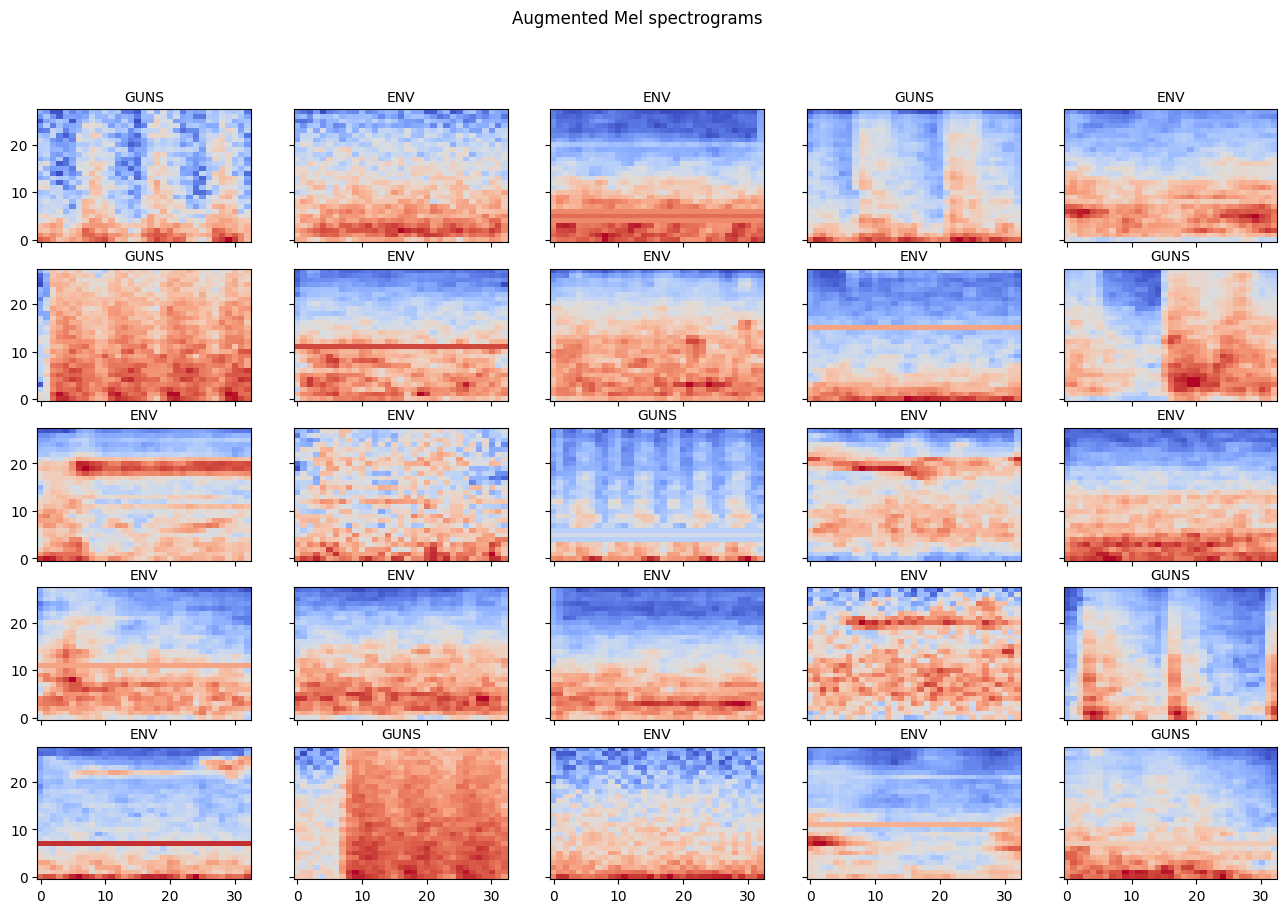

In [24]:
rows = 5
cols = 5
i = 0
fig, axes = plt.subplots(rows, cols, figsize=(16, 10), sharex="all", sharey="all")

aa = zip(X_aug[:25], y_aug[:25])
for xx, yy in aa:
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    i = i + 1
    plot_spectrogram(xx, ax)
    ax.set_title(label_names[np.argmax(yy)])
plt.suptitle("Augmented Mel spectrograms")
plt.show()

In [25]:
train_ds = train_ds.cache().shuffle(35000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)


def exp_ds_dim(data, label):
    data = data[..., tf.newaxis]
    return data, label


train_ds = train_ds.map(exp_ds_dim).batch(16)
val_ds = val_ds.map(exp_ds_dim).batch(16)
test_ds = test_ds.map(exp_ds_dim).batch(16)

In [27]:
input_shape = (28, 28, 1)
print("Input shape:", input_shape)
num_labels = len(label_names)

model = tfk.models.Sequential(
    [
        tfk.layers.Input(shape=input_shape),
        tfk.layers.Conv2D(64, 3, activation="relu", padding="valid"),
        tfk.layers.Dropout(0.2),
        tfk.layers.MaxPooling2D(),
        tfk.layers.Conv2D(128, 3, activation="relu", padding="valid"),
        tfk.layers.MaxPooling2D(),
        tfk.layers.Conv2D(128, 3, activation="relu", padding="valid"),
        # tfk.layers.Dropout(0.1),
        tfk.layers.MaxPooling2D(),
        tfk.layers.Conv2D(256, (1, 1), activation="relu"),
        tfk.layers.Conv2D(128, (1, 1), activation="relu"),
        tfk.layers.Conv2D(num_labels, (1, 1), activation="sigmoid"),
        tfk.layers.GlobalMaxPooling2D(),
    ]
)
model.summary()

Input shape: (28, 28, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 1, 1, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 1, 1, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 1, 1, 2)        │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 2)              │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,258 (1.10 MB)

 Trainable params: 288,258 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
def lr_schedule(epoch):
    if epoch > 20:
        return 0.00002
    if epoch > 10:
        return 0.00006
    elif epoch > 2:
        return 0.0001
    else:
        return 0.00001  # Warmup


learnRate_cb = tfk.callbacks.LearningRateScheduler(lr_schedule)

# Early stop callback
earlyStop_cb = tfk.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=7,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

callbacks = [learnRate_cb, earlyStop_cb]

Epoch 1/50


507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - categorical_accuracy: 0.6480 - false_negatives_1: 1738.8071 - false_positives_1: 1042.7638 - loss: 0.6376 - precision_1: 0.6104 - recall_1: 0.4570 - true_negatives_1: 3029.1733 - true_positives_1: 2333.1299 - val_categorical_accuracy: 0.8244 - val_false_negatives_1: 128.0000 - val_false_positives_1: 151.0000 - val_loss: 0.5288 - val_precision_1: 0.8079 - val_recall_1: 0.8322 - val_true_negatives_1: 612.0000 - val_true_positives_1: 635.0000 - learning_rate: 1.0000e-05
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - categorical_accuracy: 0.8669 - false_negatives_1: 559.9882 - false_positives_1: 561.5807 - loss: 0.5001 - precision_1: 0.8550 - recall_1: 0.8571 - true_negatives_1: 3510.3562 - true_positives_1: 3511.9487 - val_categorical_accuracy: 0.8978 - val_false_negatives_1: 79.0000 - val_false_positives_1: 100.0000 - val_loss: 0.4518 - val_precision_1: 0.8724 - val_recall_1: 0.8965 - val_true_negatives_1: 663.0000 - val_true_positives

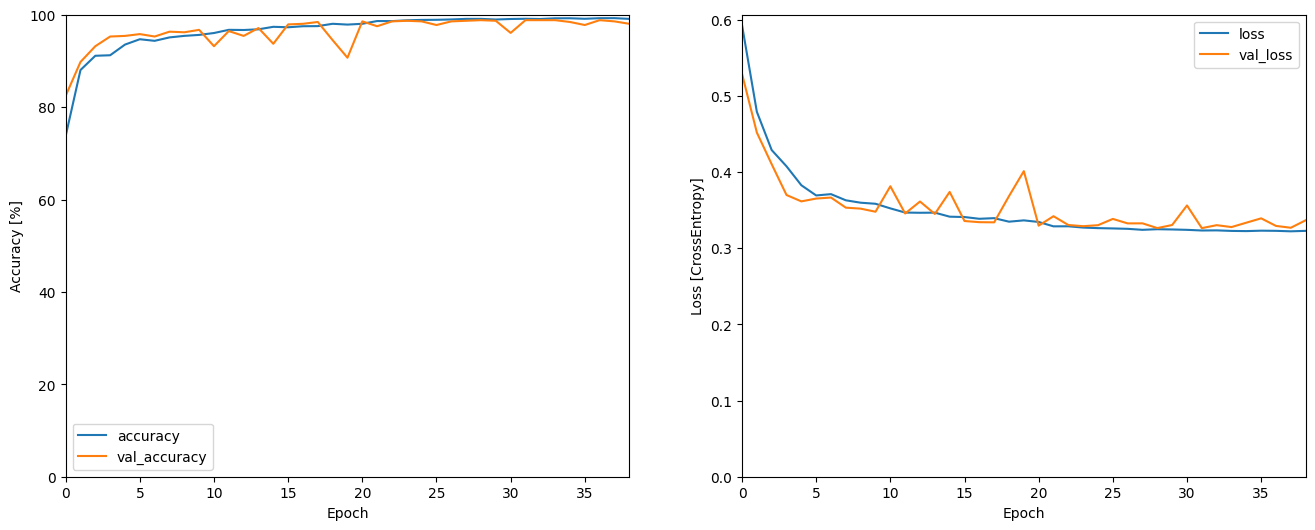

In [29]:
EPOCHS = 50
model.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        # "accuracy",
        tfk.metrics.CategoricalAccuracy(),
        tfk.metrics.FalseNegatives(),
        tfk.metrics.TrueNegatives(),
        tfk.metrics.FalsePositives(),
        tfk.metrics.TruePositives(),
        tfk.metrics.Precision(),
        tfk.metrics.Recall(),
    ],
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

plot_eval(history)

a = model.evaluate(test_ds, return_dict=True)
print(f"Accuracy: {100*a['categorical_accuracy']:0.2f}% \U0001f44d \nLoss:     {a['loss']:0.4f}")

In [18]:
# Save model
import pickle

with open("GunSound_FCN.pkl", "wb") as f:
    pickle.dump(model, f)